In [1]:
import torch

import numpy as np

from PIL import Image
from lavis.models import load_model_and_preprocess
from lavis.models.blip_diffusion_models.utils import preprocess_canny

/opt/conda/lib/python3.8/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [2]:
torch.cuda.is_available()

True

In [3]:
model, vis_preprocess, txt_preprocess = load_model_and_preprocess(
    "blip_diffusion", "canny", device="cuda", is_eval=True)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/opt/conda/lib/python3.8/site-packages/diffusers/configuration_utils.py:215: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality

No ctx_embeddings_cache found in /root/.cache/torch/hub/checkpoints/blip-diffusion


In [4]:
def generate_canny(cond_image_input, low_threshold, high_threshold):
    # convert cond_image_input to numpy array
    cond_image_input = np.array(cond_image_input).astype(np.uint8)

    # canny_input, vis_control_image = preprocess_canny(cond_image_input, 512, low_threshold=100, high_threshold=200)
    vis_control_image = preprocess_canny(cond_image_input, 512, low_threshold=low_threshold, high_threshold=high_threshold)

    return vis_control_image 

### Description
This demo shows how to transfer visuals of a style image for stylization. It works in the following steps:

1. The model extract BLIP-embeddings from ``style_subject`` and ``style_image``.
2. Extract canny edges from ``cldm_cond_image``.
3. The model performs stylization using the prompt "A ``${BLIP-embedding} ${tgt_subject} ${text_prompt}``", with ``cldm_cond_image`` as structural control.

Tips:
1. It is suggested use prompt that is aligned with the edge map. Otherwise, the model won't produce generations respecting the prompts.

2. Using condition images with clean background helps to better encode the style, especially the subject in the condition image is highly personalized.

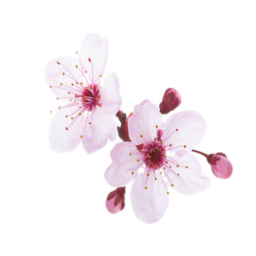

In [5]:
style_subject = "flower" # subject that defines the style
tgt_subject = "teapot"  # subject to generate.

text_prompt = "on a marble table"

cond_subjects = [txt_preprocess["eval"](style_subject)]
tgt_subjects = [txt_preprocess["eval"](tgt_subject)]
text_prompt = [txt_preprocess["eval"](text_prompt)]

cldm_cond_image = Image.open("../images/kettle.jpg").convert("RGB")

style_image = Image.open("../images/flower.jpg").convert("RGB")
display(style_image.resize((256, 256), resample=Image.BILINEAR))
style_image = vis_preprocess["eval"](style_image).unsqueeze(0).cuda()


### Canny Edge Detection

The quality of canny edge detection is important to create visually pleasant generations.

We generally find using dense canny edge maps can better control the generation.
In contrast, if edges are sparse, the model will find it hard to clearly segment target subject from background, causing styling effect to extend beyond subject silhouette or blurry generation.

Two important factors to create dense canny maps:
1. to select texture-rich subjects in preference to textureless subjects. Particular art styles are usually not texture-rich, such as anime, cartoon etc, and may be less ideal.
2. to experiment with different canny thresholding. Any edges with intensity gradient more than canny_high_threshold are sure to be edges. Those below canny_low_threshold are sure to be non-edges, and will be discarded. See section 5: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html for reference.
**Namely, if dense edges are preferred, setting low values for both threshold helps.**

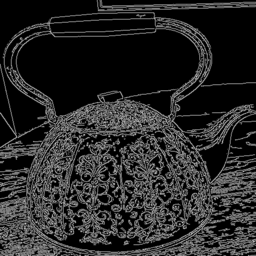

In [6]:

canny_low_threshold = 30
canny_high_threshold = 70

cond_image_input = generate_canny(cldm_cond_image, canny_low_threshold, canny_high_threshold)

cond_image_display = cond_image_input.resize((256, 256), resample=Image.BILINEAR)
display(cond_image_display)

In [7]:
samples = {
    "cond_images": style_image,
    "cond_subject": cond_subjects,
    "tgt_subject": tgt_subjects,
    "prompt": text_prompt,
    "cldm_cond_image": cond_image_input.convert("RGB"),
}

/export/home/workspace/LAVIS-Diffusion/LAVIS/lavis/models/blip_diffusion_models/blip_diffusion.py:325: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, self.unet.in_channels, height // 8, width // 8),
/export/home/workspace/LAVIS-Diffusion/LAVIS/lavis/models/blip_diffusion_models/blip_diffusion.py:331: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  self.unet.in_channels,
100%|██████████| 51/51 [00:07<00:00,  7.26it/s]


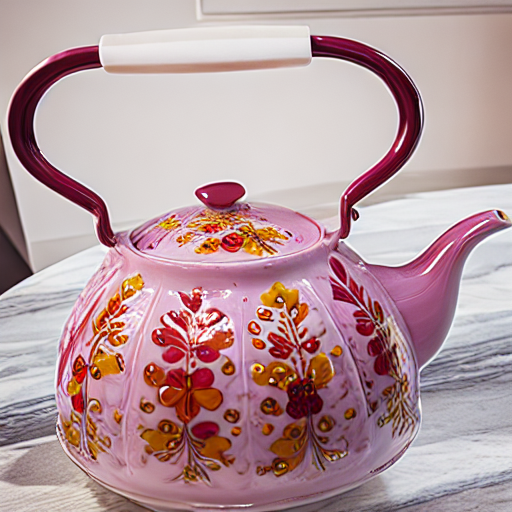

100%|██████████| 51/51 [00:06<00:00,  7.39it/s]


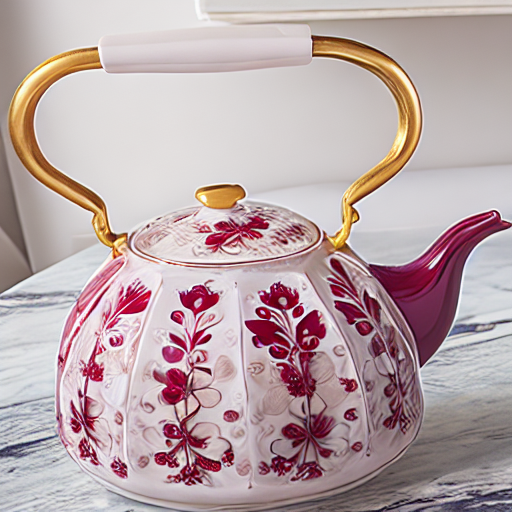

In [8]:
num_output = 2

iter_seed = 88888
guidance_scale = 7.5
num_inference_steps = 50
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"


for i in range(num_output):
    output = model.generate(
        samples,
        seed=iter_seed + i,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        neg_prompt=negative_prompt,
        height=512,
        width=512,
    )

    display(output[0])
